In [1]:
# libraries
using Flux, Flux.Data.MNIST   # the julia ml library
using Images                  # image processing and machine vision for julia
using MLJ                     # make_blobs

using LinearAlgebra    # pinv pseudo-inverse matrix
using Metrics          # r2-score
using Random
using StatsBase        # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


In [2]:
# load mnist from Flux
labels = MNIST.labels()
images = MNIST.images()
length(images), length(labels)


(60000, 60000)

,,,,

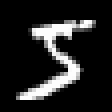
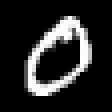
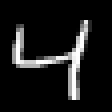
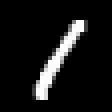
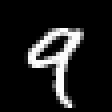

1×5 Adjoint{Int64,Array{Int64,1}}:
 5  0  4  1  9

In [3]:
# trainset/testset
imagesTrainOriginal = images[1:50000]
imagesTestOriginal  = images[50001:60000]

labelsTrainOriginal = labels[1:50000]
labelsTestOriginal  = labels[50001:60000]

display(imagesTrainOriginal[1:5])
labelsTrainOriginal[1:5]'

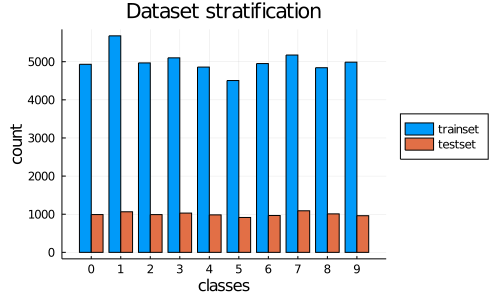

In [4]:
# check for unique labels
l = (unique(labels))
sort!(l)
N = size(l)[1]

# distribution of labels
d1 = countmap(labelsTrainOriginal)
d1 = DataFrame([(k, v) for (k,v) in d1])
rename!(d1, ["class","train_qty"])

d2 = countmap(labelsTestOriginal)
d2 = DataFrame([(k, v) for (k,v) in d2])
rename!(d2, ["class","test_qty"])

df = innerjoin(d1, d2, on = :class)
sort!(df,[:class])
#display(df)

M = df |> Array
p1 = groupedbar(M[:, 2:3],
    bar_position = :dodge,
    size=(500,300),
    xtick=(1:N, l),
    legend=:outerright,
    label=["trainset" "testset"])
p1 = title!("Dataset stratification", xlabel="classes", ylabel="count")
